In [6]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: may have to add '..' if move from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot.util import *

import matplotlib.pyplot as plt 
import numpy as np 
from pprint import pprint as pp 
import pandas as pd

# Tab after '.' to get all methods 
# Tab Shift after () to get documentation.
# To read excel data:
# pd.read_excel('afn_infil_data.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
df = pd.read_excel('afn_infil_data.xlsx')
df = df.drop(columns=['avg1', 'avg2'])
df['afn_infil'] *= 1.225 # kg/m3
df['ifrea_infil'] *= 1.225 # kg/m3

df.head()

,ifrea_infil,afn_infil,mean_dpa
0,0.000679,0.000424,-0.234993
1,0.000681,0.000530,-0.331139
2,0.000681,0.000581,-0.334124
3,0.000680,0.000635,-0.297967
4,0.000680,0.000603,-0.285740


Text(0, 0.5, 'infil [m3/s]')

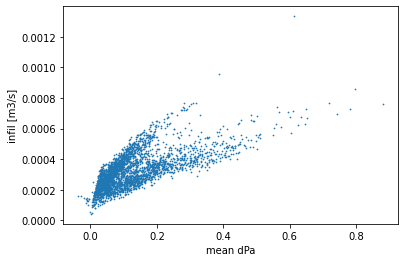

In [139]:
# Plot dP against afn_infil
# Note that negative convention for dPa indicates 
# air coming in, so we should flip sign. 

df['mean_dpa'] = -df['mean_dpa']

f, a, = plt.subplots(1, 1)
a.scatter(df.mean_dpa, df.afn_infil, s=0.5)
a.set_xlabel('mean dPa')
a.set_ylabel('infil [m3/s]')

# This is a very noisy version of what we expect, 
# logarithmic increase in infiltration with 
# increase in Pa difference. But data is noisy 
# due to impact of multiple walls, openings. 

In [140]:
# Calculate regression to get Cw and n 

# remove negative vals for log 
mask_idx = np.where(df.mean_dpa > 0)[0]
log_mean_dpa = np.log(df.mean_dpa[mask_idx])
log_afn_infil = np.log(df.afn_infil[mask_idx])

# add 1s row so that we have a bias
# X: 2, 2915
# y: 1, 2915 
X = np.array(
    [log_mean_dpa,
    np.ones_like(log_mean_dpa)]) 
y = log_afn_infil


# 1. Projection matrix 
X = X.T  # 2915, 2
P = X @ np.linalg.pinv(X.T @ X) @ X.T
print('Proj matrix', P.shape)  # 2915, 2915 

# Project y onto X plane 
yhat1 = P @ y

# 2. Weights matrix 
B = np.linalg.pinv(X.T @ X) @ X.T @ y
print('Weights matrix', B.shape)  # (2, )
yhat2 = X @ B 

assert np.sum(yhat1 - yhat2) < 1e-10


Proj matrix (2915, 2915)
Weights matrix (2,)


In [141]:
# Extract weights from Beta matrix 
n = B[0] 
log_Cw = B[1]  # bias is Cw

print('Cw:', np.exp(log_Cw))
print('n: ', n)

# n, flow exponent is a lot less leaky then would be expected 
# Cw, flow coefficient looks reasonable

Cw: 0.0006443585639567819
n:  0.31427043569736646


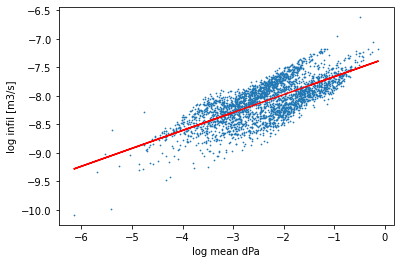

In [142]:
f, a, = plt.subplots(1, 1)
a.scatter(log_mean_dpa, log_afn_infil, s=0.5)
a.set_xlabel('log mean dPa')
a.set_ylabel('log infil [m3/s]')

# Plot regression line, looks reasonable  
a.plot(log_mean_dpa, (n * log_mean_dpa) + log_Cw, 'red')

In [143]:
# Doesn't work...
# Now calculate updated Cw that gets us to infil mean = 0.000569

target_infil = 0.000569
print('target mean: ', np.log(target_infil))
print('current reg mean:', np.mean(yhat2))
print('current mean:', np.mean(log_afn_infil))
print('--')
log_Cw_delta = np.log(target_infil) - np.mean(yhat2)
print('Cw increase: ', Cw_delta)

# np.mean(yhat2) + log_Cw_delta
log_Cw2 = log_Cw + log_Cw_delta

target mean:  -7.471630123837944
current reg mean: -8.092994319355654
current mean: -8.092994319355645
--
Cw increase:  0.8243050395143943


Cw should be: 0.0011994513741316179
 n should be: 0.31427043569736646


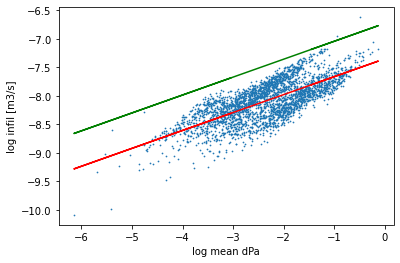

In [144]:
# Doesn't work...

f, a, = plt.subplots(1, 1)
a.scatter(log_mean_dpa, log_afn_infil, s=0.5)
a.set_xlabel('log mean dPa')
a.set_ylabel('log infil [m3/s]')

# Plot regression line
a.plot(log_mean_dpa, (n * log_mean_dpa) + log_Cw, 'red')
a.plot(log_mean_dpa, (n * log_mean_dpa) + log_Cw2, 'green')

print('Cw should be:', np.exp(log_Cw2))
print(' n should be:', n)
